# Homework Assignment 2

### Contents : 
1. Code :- 
    * primitives.py
    * evaluation_based_sampling.py
    * graph_based_sampling
    * histogram_plot.py
2. Output :-
    * Evaluation-based sampling
        * Deterministic cases
        * Probablistic cases
        * Daphne Prog 1 - 4
        * Histogram plots and stats for marginal Exepectation of all the dimension for Prog 1-4
    * Graph-based sampling
        * Deterministic cases
        * Probablistic cases
        * Daphne Prog 1 - 4
        * Histogram plots and stats for marginal Exepectation of all the dimension for Prog 1- 4
**GitHub link** - https://github.com/GauravBh1010tt

## Code for primitives.py

In [3]:
import torch
import re
import operator as op
from scipy import stats

#TODO

def sorted_alnum(l):
	convert = lambda text: int(text) if text.isdigit() else text
	alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
	return sorted(l, key = alphanum_key)

Symbol = str              
Number = (torch.int32, torch.float32, torch.float64)     
Float = (torch.float32, torch.float64)
Atom   = (Symbol, Number) 
List   = torch.tensor           
Exp    = (Atom, List)     
Env    = dict             

def create_env():
	env = Env()
	env.update(vars(torch)) # sin, cos, sqrt, pi, ...
	env.update({
		'+':torch.add, '-':torch.sub, '*':torch.mul, '/':torch.div, 
		'>':torch.greater, '<':torch.less, '>=':torch.greater_equal, '<=':torch.less_equal, '=':torch.equal, 
		'abs':     abs,
		'append':  op.add,  
		'apply':   lambda proc, args: proc(*args),
		'begin':   lambda *x: x[-1],
		'car':     lambda x: x[0],
		'cdr':     lambda x: x[1:], 
		'cons':    lambda x,y: [x] + y,
		'eq?':     op.is_, 
		'expt':    pow,
		'equal?':  op.eq, 
		'length':  len, 
		'list':    lambda *x: List(x), 
		'list?':   lambda x: isinstance(x, List), 
		'map':     map,
		'max':     max,
		'min':     min,
		'not':     op.not_,
		'null?':   lambda x: x == [], 
		'number?': lambda x: isinstance(x, Number),  
		'print':   print,
		'procedure?': callable,
		'round':   round,
		'symbol?': lambda x: isinstance(x, Symbol),
	})
	return env

class Env(dict):
	"An environment: a dict of {'var': val} pairs, with an outer Env."
	def __init__(self, parms=(), args=(), outer=None):
		self.update(zip(parms, args))
		self.outer = outer
	def find(self, var):
		"Find the innermost Env where var appears."
		return self if (var in self) else self.outer.find(var)

class Procedure(object):
	"A user-defined Scheme procedure."
	def __init__(self, parms, body, env):
		self.parms, self.body, self.env = parms, body, env
	def __call__(self, *args): 
		return eval(self.body, Env(self.parms, args, self.env))

global_env = create_env()

def eval(x, env=global_env):
	if isinstance(x, Symbol):    # variable reference
		return env.find(x)[x]
	elif not isinstance(x, list):# constant 
		return torch.tensor(x)
	
	op, *args = x       
	
	if op == 'quote':            # quotation
		return args[0]

	elif op == 'if':             # conditional
		(test, conseq, alt) = args
		exp = (conseq if eval(test, env) else alt)
		return eval(exp, env)
	elif op == 'define':         # definition
		(symbol, exp) = args
		env[symbol] = eval(exp, env)
	elif op == 'set!':           # assignment
		(symbol, exp) = args
		env.find(symbol)[symbol] = eval(exp, env)
	elif op == 'lambda':         # procedure
		(parms, body) = args
		return Procedure(parms, body, env)
	elif op == 'vector':
		out = [eval(i, env) for i in args]
		try:	
			return torch.stack(out)
		except Exception as e:
			return out
	elif op == 'let':
		env[args[0][0]] = eval(args[0][1], env)
		return eval(args[1], env)
	
	elif op == 'get':
		if eval(args[1], env).dtype in ['torch.float32', 'torch.float64']:
			return eval(args[0], env)[float(eval(args[1], env))]
		else:
			return eval(args[0], env)[int(eval(args[1], env))]
	elif op == 'put':
		vec,a,b = eval(args[0], env), eval(args[1], env), eval(args[2], env)
		if eval(a, env).dtype in ['torch.float32', 'torch.float64']:
			vec[float(a)] = b
		else:
			vec[int(a)] = b
		return (vec)
	elif op == 'first':
		try:
			return eval(args[0], env)[0]
		except:
			return eval(args[0])[0]
	elif op == 'last':
		return eval(args[0], env)[-1]

	elif op == 'second':
		try:
			return eval(args[0], env)[1]
		except:
			return eval(args[0])[1]

	elif op =='rest':
		return eval(args[0], env)[2:]

	elif op == 'append':
		try:
			return torch.cat([eval(args[0], env), eval(args[1], env).unsqueeze(0)])
		except:
			return torch.cat([env[args[0]], env[args[1]].unsqueeze(0)])
	elif op == 'hash-map':
		hmap = {}
		for i in range(0,len(args),2):
			hmap[args[i]] = eval(args[i+1], env)
		return hmap
	elif op == 'normal':
		#print ('asgas', args)
		return torch.distributions.Normal(eval(args[0], env).float(),eval(args[1], env).float())

	elif op == 'beta':
		return torch.distributions.Beta(eval(args[0], env).float(),eval(args[1], env).float())
	elif op == 'exponential':
		return torch.distributions.Exponential(eval(args[0], env).float())
	elif op == 'uniform':
		return torch.distributions.Uniform(eval(args[0], env).float(),eval(args[1], env).float())
	elif op == 'sample':
		return eval(args[0], env).sample()
	elif op == 'discrete':
		#print ('in dis', args)
		return torch.distributions.Categorical(eval(args[0], env))

	elif op == 'defn':
		name, param, body = args
		env[name] = Procedure(param, body, env)
		return None
	elif op == 'observe':
		return eval(args[0], env).sample()

	elif op == 'mat-transpose':
		return torch.transpose(eval(args[0], env),1,0)

	elif op == 'mat-tanh':
		return torch.tanh(eval(args[0], env))

	elif op == 'mat-add':
		return torch.add(eval(args[0], env),eval(args[1], env))
	
	elif op == 'mat-mul':
		return torch.matmul(eval(args[0], env).float(),eval(args[1], env).float())
	
	elif op == 'mat-repmat':
		return eval(args[0], env).repeat(eval(args[1], env).item(),eval(args[2], env).item())
	else:
		proc = eval(op, env)
		vals = [eval(arg, env) for arg in args]
		return proc(*vals)

## Code for evaluation_based_sampling.py

In [ ]:
from daphne import daphne
from tests import is_tol, run_prob_test,load_truth
from primitives import *

env = create_env()

def evaluate_program(ast, env=global_env):
    """Evaluate a program as desugared by daphne, generate a sample from the prior
        Args:
            ast: json FOPPL program
        Returns: sample from the prior of ast
    """
    for i in ast:
        val = eval(i, env)
    return val, env


def get_stream(ast):
    """Return a stream of prior samples"""
    while True:
        #for i in ast:
        yield evaluate_program(ast, env)
    

def run_deterministic_tests():
    
    for i in range(1,14):
        #note: this path should be with respect to the daphne path!
        ast = daphne(['desugar', '-i', '/Users/gaurav/Desktop/CS532-HW2/programs/tests/deterministic/test_{}.daphne'.format(i)])
        truth = load_truth('programs/tests/deterministic/test_{}.truth'.format(i))
        ret, sig = evaluate_program(ast)

        try:
            assert(is_tol(ret, truth))
        except AssertionError:
            raise AssertionError('return value {} is not equal to truth {} for exp {}'.format(ret,truth,ast))
        
        print('Test passed')
        
    print('All deterministic tests passed')
    


def run_probabilistic_tests():

    print ('running tests now')
    
    num_samples=1e5
    max_p_value = 1e-4
    
    for i in range(1,7):
        #note: this path should be with respect to the daphne path!        
        ast = daphne(['desugar', '-i', '/Users/gaurav/Desktop/CS532-HW2/programs/tests/probabilistic/test_{}.daphne'.format(i)])
        truth = load_truth('programs/tests/probabilistic/test_{}.truth'.format(i))
        
        stream = get_stream(ast)

        p_val = run_prob_test(stream, truth, num_samples)
        
        print('p value', p_val)
        assert(p_val > max_p_value)
    
    print('All probabilistic tests passed')

        
if __name__ == '__main__':

    run_deterministic_tests()
    run_probabilistic_tests()

    for i in range(1,5):
        ast = daphne(['desugar', '-i', '/Users/gaurav/Desktop/CS532-HW2/programs/{}.daphne'.format(i)])

        print('\n\n\nSample of prior of program {}:'.format(i))
        print(evaluate_program(ast)[0])

## Code for graph_based_sampling.py

In [ ]:
import torch
import torch.distributions as dist

from daphne import daphne
from primitives import *
from tests import is_tol, run_prob_test,load_truth

env = create_env()

env.update({
	'vector' : lambda *x: eval(['vector', x]),
	'hash-map': lambda *x: eval(['hash-map', x]),
	})

def deterministic_eval(exp):
	"Evaluation function for the deterministic target language of the graph based representation."
	if type(exp) is list:
		op = exp[0]
		args = exp[1:]
		return env[op](*map(deterministic_eval, args))
	elif type(exp) is int or type(exp) is float:
		# We use torch for all numerical objects in our evaluator
		return torch.tensor(float(exp))
	else:
		raise("Expression type unknown.", exp)


def sample_from_joint(graph):
	"This function does ancestral sampling starting from the prior."
	# TODO insert your code here
	search_graph = graph[1]['P']
	ret = {}
	search = list(search_graph.keys())
	search = sorted_alnum(search)
	for node in search:
        if search_graph[node][0] == 'sample*':
            search_graph[node][0] = 'sample'
        elif search_graph[node][0] == 'observe*'::
            search_graph[node][0] = 'observe'
        val = eval(search_graph[node], env)
        ret[node] = val.item()
        env[node] = val

	if isinstance(graph[-1], list):
		return eval(graph[-1], env)

	return [ret[graph[-1]]]


def get_stream(graph):
	"""Return a stream of prior samples
	Args: 
		graph: json graph as loaded by daphne wrapper
	Returns: a python iterator with an infinite stream of samples
		"""
	while True:
		yield sample_from_joint(graph)


#Testing:

def run_deterministic_tests():

	print ('running det')
	
	for i in range(1,13):
		#note: this path should be with respect to the daphne path!
		graph = daphne(['graph','-i','/Users/gaurav/Desktop/CS532-HW2/programs/tests/deterministic/test_{}.daphne'.format(i)])
		truth = load_truth('programs/tests/deterministic/test_{}.truth'.format(i))

		ret = deterministic_eval(graph[-1])
		try:
			assert(is_tol(ret, truth))
		except AssertionError:
			raise AssertionError('return value {} is not equal to truth {} for graph {}'.format(ret,truth,graph))
		
		print('Test passed')
		
	print('All deterministic tests passed')
	


def run_probabilistic_tests():
	
	#TODO: 
	num_samples=1e5
	max_p_value = 1e-4
	
	for i in range(1,7):
		#note: this path should be with respect to the daphne path!        
		graph = daphne(['graph', '-i', '/Users/gaurav/Desktop/CS532-HW2/programs/tests/probabilistic/test_{}.daphne'.format(i)])
		truth = load_truth('programs/tests/probabilistic/test_{}.truth'.format(i))
        
		stream = get_stream(graph)
		
		p_val = run_prob_test(stream, truth, num_samples)
		
		print('p value', p_val)
		assert(p_val > max_p_value)
	
	print('All probabilistic tests passed')    

		
		
if __name__ == '__main__':
	
	run_deterministic_tests()
	run_probabilistic_tests()

	for i in range(1,5):
		graph = daphne(['graph','-i','/Users/gaurav/Desktop/CS532-HW2/programs/{}.daphne'.format(i)])
		print('\n\n\nSample of prior of program {}:'.format(i))
		print(sample_from_joint(graph))    


## Code for plotting histogram

In [147]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

flag = 1 # eval - 0, graph - 1

graphs = {}
for i in range(1,5):
    
    if flag:
        graphs[i] = daphne(['graph','-i','/Users/gaurav/Desktop/CS532-HW2/programs/{}.daphne'.format(i)])
    else:
        graphs[i] = daphne(['desugar', '-i', '/Users/gaurav/Desktop/CS532-HW2/programs/{}.daphne'.format(i)])

hmap = {}

for j in range(4):
    hmap[j+1] = []

samples = 1000

for k in range(samples):
    for i in range(1,5):
        if flag:
            hmap[i].append(sample_from_joint(graphs[i]))
        else:
            hmap[i].append(evaluate_program(graphs[i])[0])

#out1 = torch.stack(hmap[1]).unsqueeze(1)
out1 = torch.tensor(hmap[1])
out2 = torch.stack(hmap[2])
out3 = torch.stack(hmap[3])

out40 = torch.stack([i[0] for i in hmap[4]]).squeeze()
out41 = torch.stack([i[1] for i in hmap[4]]).squeeze()
out42 = torch.stack([i[2] for i in hmap[4]]).squeeze()
out43 = torch.stack([i[3] for i in hmap[4]]).squeeze()

out = out1 # sample output of the program
space = 3

def plot_hist(out, space):

    with PdfPages('foo.pdf') as pdf:

        fig = plt.figure(figsize=(10, 5))

        fig.suptitle('Marginal expectation of all dims of dim - Prog 1', fontsize=16, y=1)

        G = GridSpec(int(out.shape[1]/space)+1,space) 
        count = 0

        for i in range(0, int(out.shape[1]/space)+1):

            for j in range(space):

                if (i*space+j)<out.shape[1]:
                    axes_1 = fig.add_subplot(G[i, j])
                    axes_1.set_title('Dim '+str(i*space+j))
                    axes_1.hist(np.array(out[:,i*space+j]), alpha=0.9, label='x')

        plt.tight_layout(pad=1)

        pdf.savefig(fig)
#plot_hist(out, space)

# Outputs

# 1. evaluation based sampling

In [17]:
!python evaluation_based_sampling.py

::Test case:: 1  ::ast:: [['+', 5, 2]]     ::return:: tensor(7)
Test passed
::Test case:: 2  ::ast:: [['sqrt', 2]]     ::return:: tensor(1.4142)
Test passed
::Test case:: 3  ::ast:: [['*', 3.0, 8.0]]     ::return:: tensor(24.)
Test passed
::Test case:: 4  ::ast:: [['/', 2, 8]]     ::return:: tensor(0.2500)
Test passed
::Test case:: 5  ::ast:: [['/', 2, ['+', 3, ['*', 3, 2.7]]]]     ::return:: tensor(0.1802)
Test passed
::Test case:: 6  ::ast:: [['vector', 2, 3, 4, 5]]     ::return:: tensor([2, 3, 4, 5])
Test passed
::Test case:: 7  ::ast:: [['get', ['vector', 9, 3, 4, 5], 2]]     ::return:: tensor(4)
Test passed
::Test case:: 8  ::ast:: [['put', ['vector', 2, 3, 4, 5], 2, 3]]     ::return:: tensor([2, 3, 3, 5])
Test passed
::Test case:: 9  ::ast:: [['first', ['vector', 2, 3, 4, 5]]]     ::return:: tensor(2)
Test passed
::Test case:: 10  ::ast:: [['last', ['vector', 2, 3, 4, 5]]]     ::return:: tensor(5)
Test passed
::Test case:: 11  ::ast:: [['append', ['vector', 2, 3, 4, 5], 3.14]]   

### Histogram plot for Daphne Prog 1

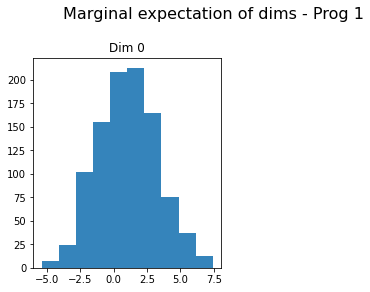

In [119]:
plot_hist(out1, 1)

In [136]:
stats.describe(out1)

DescribeResult(nobs=1000, minmax=(-5.391284, 7.4256673), mean=1.0422832, variance=4.950882, skewness=0.07110446552730725, kurtosis=-0.28236800286013164)

### Histogram plot for Daphne Prog 2

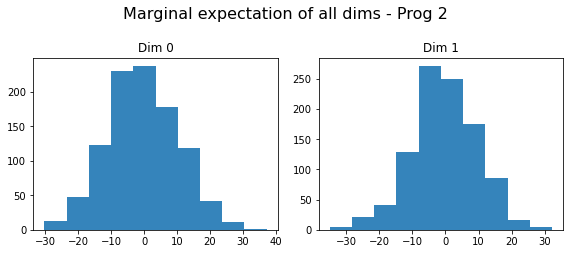

In [122]:
plot_hist(out2, 1)

In [138]:
for i in range (out2.shape[1]):
    print ('stats for dim ', i)
    print (stats.describe(out2[:,i]))

stats for dim  0
DescribeResult(nobs=1000, minmax=(-30.243967, 37.233566), mean=-0.38603723, variance=112.50985, skewness=0.07757283566218831, kurtosis=-0.13741835588351048)
stats for dim  1
DescribeResult(nobs=1000, minmax=(-34.928448, 32.21645), mean=-0.411226, variance=98.12786, skewness=-0.07109255689371265, kurtosis=0.30421912868675083)


### Histogram plot for Daphne Prog 3

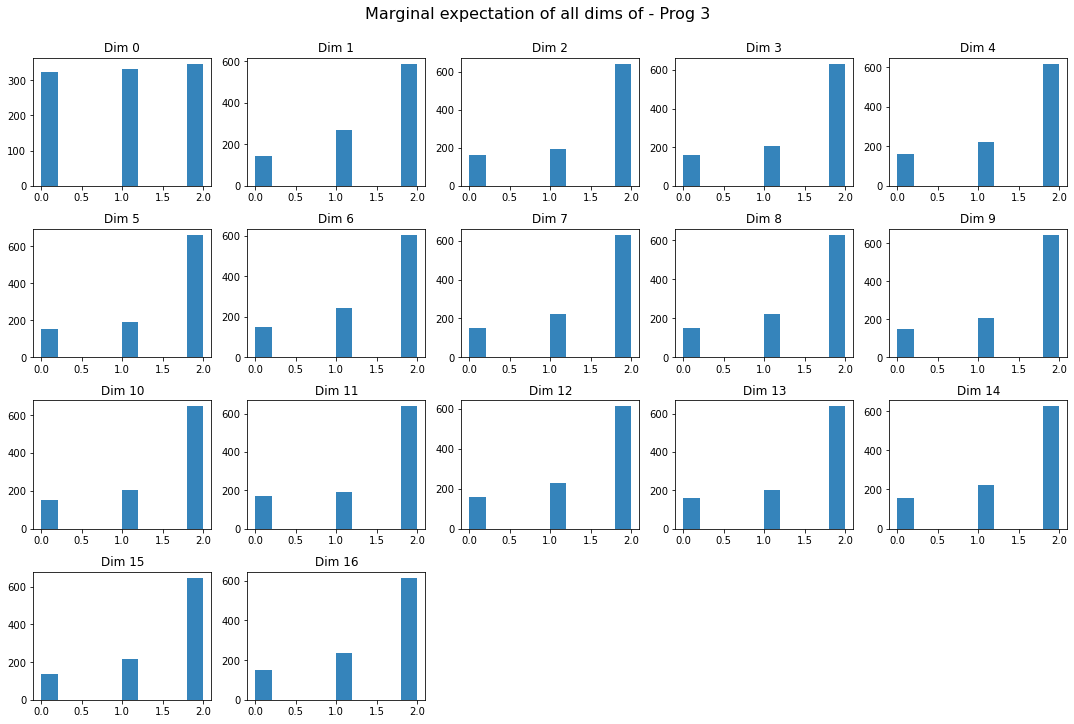

In [123]:
plot_hist(out3, 3)

In [140]:
for i in range (out3.shape[1]):
    print ('stats for dim ', i)
    print (stats.describe(out3[:,i]))

stats for dim  0
DescribeResult(nobs=1000, minmax=(0, 2), mean=1.023, variance=0.6691401401401401, skewness=-0.042332792748790815, kurtosis=-1.502850263783676)
stats for dim  1
DescribeResult(nobs=1000, minmax=(0, 2), mean=1.442, variance=0.5371731731731731, skewness=-0.9054097402388058, kurtosis=-0.5898126352713629)
stats for dim  2
DescribeResult(nobs=1000, minmax=(0, 2), mean=1.48, variance=0.5741741741741743, skewness=-1.0509918904779867, kurtosis=-0.4633614024030872)
stats for dim  3
DescribeResult(nobs=1000, minmax=(0, 2), mean=1.47, variance=0.5736736736736738, skewness=-1.0185268732547883, kurtosis=-0.5144069022989992)
stats for dim  4
DescribeResult(nobs=1000, minmax=(0, 2), mean=1.455, variance=0.5725475475475474, skewness=-0.9707871081021326, kurtosis=-0.5853774792778554)
stats for dim  5
DescribeResult(nobs=1000, minmax=(0, 2), mean=1.509, variance=0.5524714714714716, skewness=-1.1356616503242165, kurtosis=-0.2621295891177837)
stats for dim  6
DescribeResult(nobs=1000, minm

### Histogram plot for Daphne Prog 4

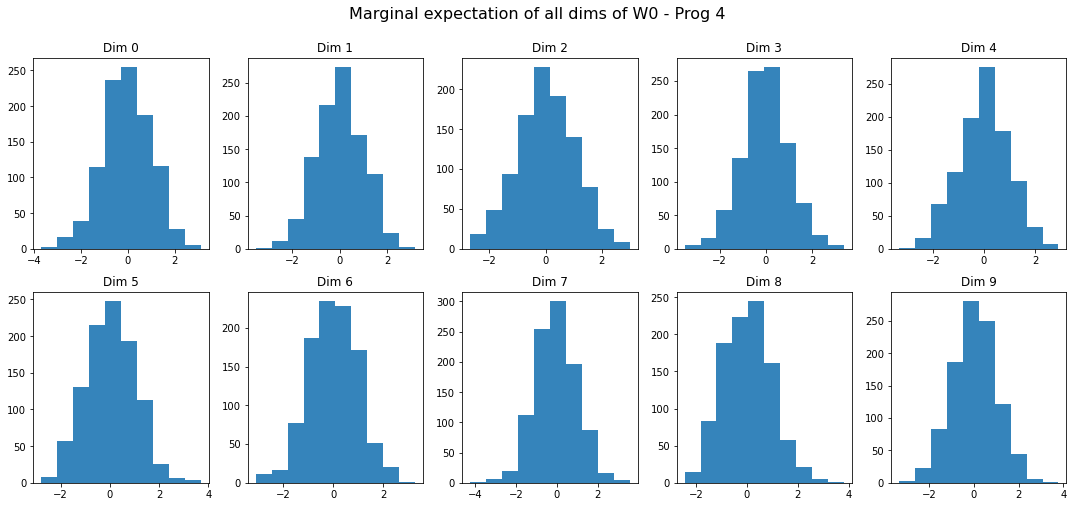

In [124]:
plot_hist(out40, 3)

In [141]:
for i in range (out40.shape[1]):
    print ('stats for dim ', i)
    print (stats.describe(out40[:,i]))

stats for dim  0
DescribeResult(nobs=1000, minmax=(-3.680703, 3.1045327), mean=-0.04343006, variance=1.0487527, skewness=-0.13382902607188957, kurtosis=0.028765655436555626)
stats for dim  1
DescribeResult(nobs=1000, minmax=(-3.536094, 3.1762466), mean=0.01251157, variance=0.96685296, skewness=-0.0464092232938494, kurtosis=-0.10113639620114778)
stats for dim  2
DescribeResult(nobs=1000, minmax=(-2.6840613, 2.9883137), mean=0.023294006, variance=1.0333512, skewness=-0.019280401397093038, kurtosis=-0.2543560202417092)
stats for dim  3
DescribeResult(nobs=1000, minmax=(-3.5058126, 3.3611019), mean=-0.026350703, variance=1.0071757, skewness=-0.04667836626679121, kurtosis=0.23925113312768476)
stats for dim  4
DescribeResult(nobs=1000, minmax=(-3.3210647, 2.919701), mean=-0.0037037525, variance=0.9677776, skewness=-0.058061339619787135, kurtosis=-0.14896236828107412)
stats for dim  5
DescribeResult(nobs=1000, minmax=(-2.7871003, 3.685819), mean=0.031126292, variance=1.0009633, skewness=0.119

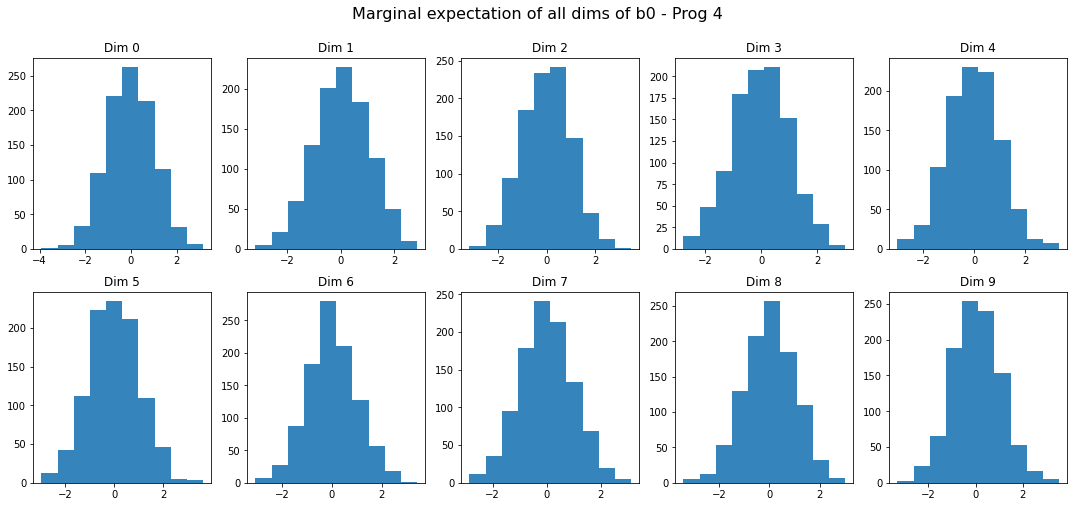

In [125]:
plot_hist(out41, 3)

In [142]:
for i in range (out41.shape[1]):
    print ('stats for dim ', i)
    print (stats.describe(out41[:,i]))

stats for dim  0
DescribeResult(nobs=1000, minmax=(-3.9174166, 3.15371), mean=-0.02677465, variance=1.0262619, skewness=0.04576510580686025, kurtosis=-0.04569460641312473)
stats for dim  1
DescribeResult(nobs=1000, minmax=(-3.1896896, 2.8614032), mean=0.038801093, variance=1.0675238, skewness=-0.09758802081249357, kurtosis=-0.19477809436750482)
stats for dim  2
DescribeResult(nobs=1000, minmax=(-3.1667445, 3.4721673), mean=-0.0077216416, variance=1.0059866, skewness=-0.03719644604106755, kurtosis=-0.12238671337771878)
stats for dim  3
DescribeResult(nobs=1000, minmax=(-2.7733593, 3.0001094), mean=-0.0067928545, variance=1.0112991, skewness=-0.06448106405148556, kurtosis=-0.2269815170511711)
stats for dim  4
DescribeResult(nobs=1000, minmax=(-2.9933019, 3.3107836), mean=-0.038975358, variance=1.0429604, skewness=0.0024051487756034232, kurtosis=-0.006042225795027889)
stats for dim  5
DescribeResult(nobs=1000, minmax=(-2.9729037, 3.620445), mean=-0.008973087, variance=1.0345876, skewness=

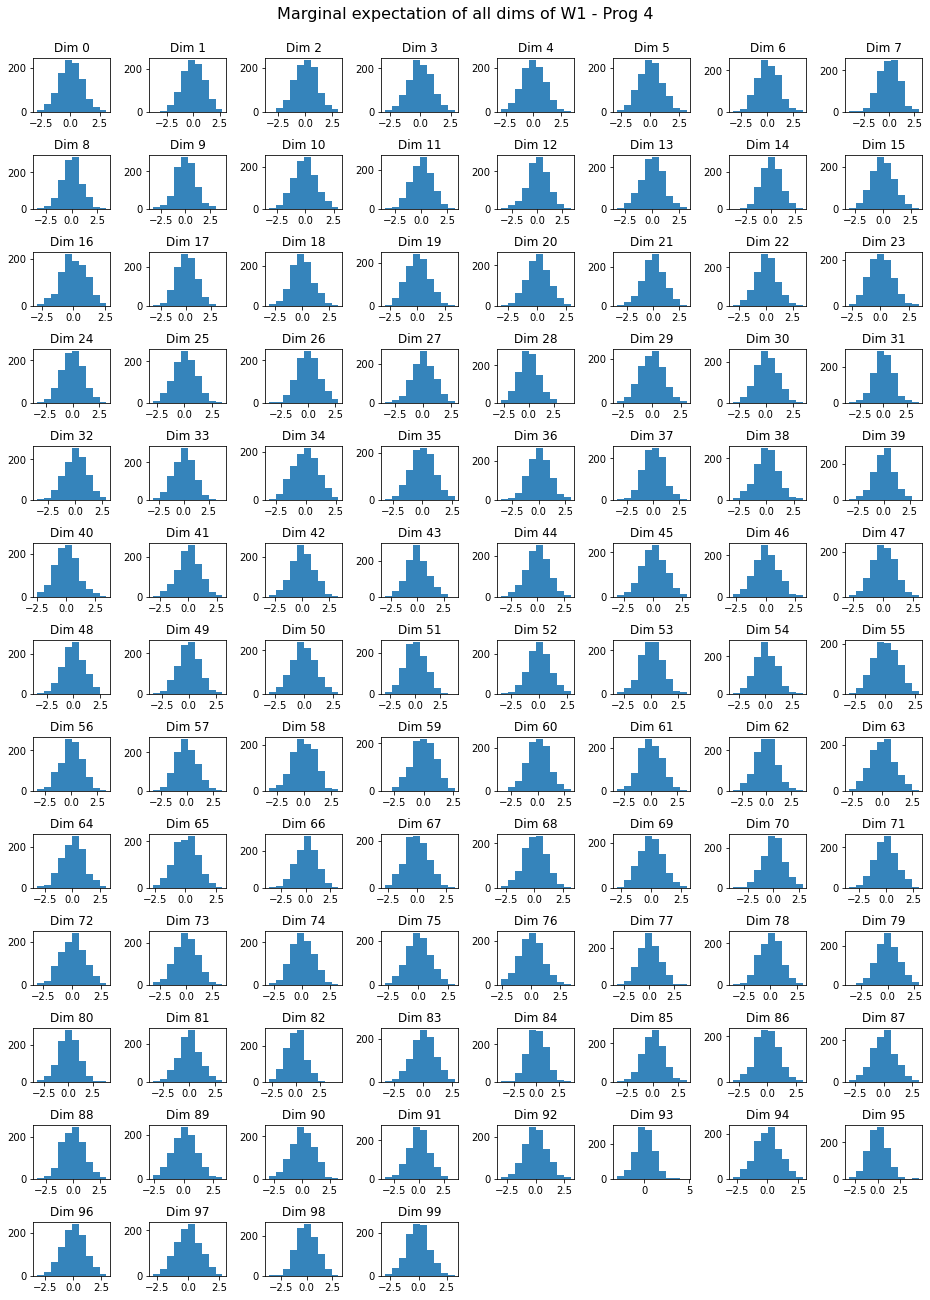

In [126]:
plot_hist(out42, 8)

In [144]:
for i in range (out42.view(samples,-1).shape[1]):
    print ('stats for dim ', i)
    print (stats.describe(out42.view(samples,-1)[:,i]))

stats for dim  0
DescribeResult(nobs=1000, minmax=(-2.843103, 3.0839727), mean=0.018152887, variance=0.9687689, skewness=0.04062937390346271, kurtosis=0.08840945298381664)
stats for dim  1
DescribeResult(nobs=1000, minmax=(-3.8286815, 2.7793221), mean=-0.022716917, variance=1.041118, skewness=-0.018304769207423466, kurtosis=-0.15928488156033183)
stats for dim  2
DescribeResult(nobs=1000, minmax=(-3.4013174, 3.119959), mean=0.02736068, variance=1.0732309, skewness=0.034674713792894336, kurtosis=-0.11821492911346043)
stats for dim  3
DescribeResult(nobs=1000, minmax=(-2.9597642, 2.829035), mean=-0.03792048, variance=0.9096473, skewness=-0.01510098519356995, kurtosis=-0.11976083348969357)
stats for dim  4
DescribeResult(nobs=1000, minmax=(-2.9173603, 3.3306842), mean=-0.019290593, variance=1.0133225, skewness=0.073626699552167, kurtosis=-0.048146825152498796)
stats for dim  5
DescribeResult(nobs=1000, minmax=(-2.8965676, 3.1373773), mean=-0.00075774407, variance=0.97381175, skewness=0.071

DescribeResult(nobs=1000, minmax=(-3.3156607, 2.7172766), mean=0.012133083, variance=1.0150822, skewness=-0.10189615049682794, kurtosis=-0.03223476139735704)
stats for dim  84
DescribeResult(nobs=1000, minmax=(-4.025395, 3.859277), mean=-0.014696416, variance=1.0836306, skewness=-0.032948262837143444, kurtosis=0.23818292082510473)
stats for dim  85
DescribeResult(nobs=1000, minmax=(-3.5322468, 3.341473), mean=0.016015727, variance=1.0391659, skewness=-0.052044560504908584, kurtosis=0.2546973583143779)
stats for dim  86
DescribeResult(nobs=1000, minmax=(-3.0115716, 3.0817196), mean=-0.023534115, variance=0.9908792, skewness=0.09915546927971847, kurtosis=0.04719238407212423)
stats for dim  87
DescribeResult(nobs=1000, minmax=(-3.0242572, 3.0392256), mean=-0.017364658, variance=1.008786, skewness=0.014048022825126152, kurtosis=-0.15626565536297976)
stats for dim  88
DescribeResult(nobs=1000, minmax=(-3.404388, 3.1485977), mean=-0.0015890598, variance=1.0626024, skewness=0.1212869379643587

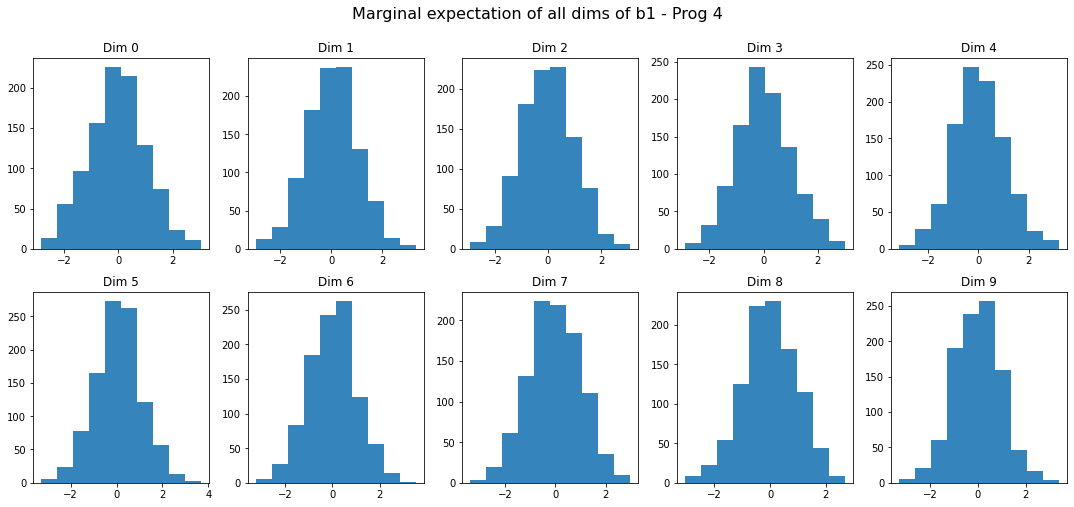

In [128]:
plot_hist(out43, 3)

In [145]:
for i in range (out43.view(samples,-1).shape[1]):
    print ('stats for dim ', i)
    print (stats.describe(out43.view(samples,-1)[:,i]))

stats for dim  0
DescribeResult(nobs=1000, minmax=(-2.839294, 3.0554962), mean=-0.021877158, variance=1.0823545, skewness=0.022508880701302362, kurtosis=-0.07899747321577077)
stats for dim  1
DescribeResult(nobs=1000, minmax=(-2.9360385, 3.2979968), mean=0.03815244, variance=1.0129781, skewness=-0.032939547342936, kurtosis=0.12438846650100333)
stats for dim  2
DescribeResult(nobs=1000, minmax=(-2.9217846, 3.0927093), mean=0.0026048394, variance=0.9502524, skewness=0.035111298677627766, kurtosis=-0.2039973936714916)
stats for dim  3
DescribeResult(nobs=1000, minmax=(-2.9082131, 2.9904919), mean=0.014037601, variance=1.0180885, skewness=0.12704756167225154, kurtosis=-0.14033984401329347)
stats for dim  4
DescribeResult(nobs=1000, minmax=(-3.1347556, 3.215716), mean=0.04996467, variance=1.0336369, skewness=0.1278971257305898, kurtosis=0.08456615655099498)
stats for dim  5
DescribeResult(nobs=1000, minmax=(-3.2777452, 3.6887658), mean=0.08242969, variance=1.016181, skewness=-0.048481665174

# 2. graph based sampling

In [64]:
!python graph_based_sampling.py

::Test case:: 1  ::graph:: [{}, {'V': [], 'A': {}, 'P': {}, 'Y': {}}, 7]     ::return:: tensor(7.)
Test passed
::Test case:: 2  ::graph:: [{}, {'V': [], 'A': {}, 'P': {}, 'Y': {}}, ['sqrt', 2]]     ::return:: tensor(1.4142)
Test passed
::Test case:: 3  ::graph:: [{}, {'V': [], 'A': {}, 'P': {}, 'Y': {}}, 24.0]     ::return:: tensor(24.)
Test passed
::Test case:: 4  ::graph:: [{}, {'V': [], 'A': {}, 'P': {}, 'Y': {}}, 0.25]     ::return:: tensor(0.2500)
Test passed
::Test case:: 5  ::graph:: [{}, {'V': [], 'A': {}, 'P': {}, 'Y': {}}, 0.18018018018018014]     ::return:: tensor(0.1802)
Test passed
::Test case:: 6  ::graph:: [{}, {'V': [], 'A': {}, 'P': {}, 'Y': {}}, ['vector', 2, 3, 4, 5]]     ::return:: tensor([[2., 3., 4., 5.]])
Test passed
::Test case:: 7  ::graph:: [{}, {'V': [], 'A': {}, 'P': {}, 'Y': {}}, 4]     ::return:: tensor(4.)
Test passed
::Test case:: 8  ::graph:: [{}, {'V': [], 'A': {}, 'P': {}, 'Y': {}}, ['vector', 2, 3, 3, 5]]     ::return:: tensor([[2., 3., 3., 5.]])
Tes

### Histogram plot for Daphne Prog 1

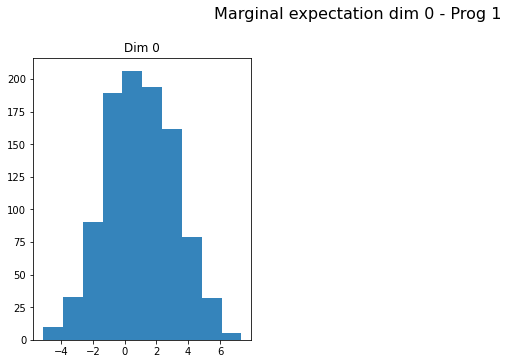

In [84]:
plot_hist(out1, 1)

In [149]:
stats.describe(out1)

DescribeResult(nobs=1000, minmax=(array([-5.597617], dtype=float32), array([8.699574], dtype=float32)), mean=array([1.0011797], dtype=float32), variance=array([4.8479066], dtype=float32), skewness=array([0.04848601], dtype=float32), kurtosis=array([0.0101831], dtype=float32))

### Histogram plot for Daphne Prog 2

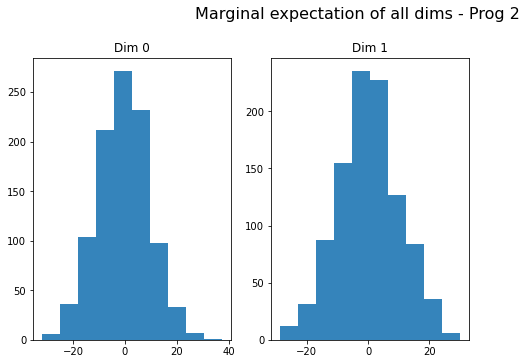

In [85]:
plot_hist(out2, 2)

In [148]:
for i in range (out2.shape[1]):
    print ('stats for dim ', i)
    print (stats.describe(out2[:,i]))

stats for dim  0
DescribeResult(nobs=1000, minmax=(-41.08525, 35.020794), mean=0.38461292, variance=109.00462, skewness=-0.062059840012514994, kurtosis=0.05564005388260185)
stats for dim  1
DescribeResult(nobs=1000, minmax=(-28.941366, 29.54979), mean=0.05419165, variance=100.76962, skewness=0.039000986172782234, kurtosis=-0.2196565047518626)


### Histogram plot for Daphne Prog 3

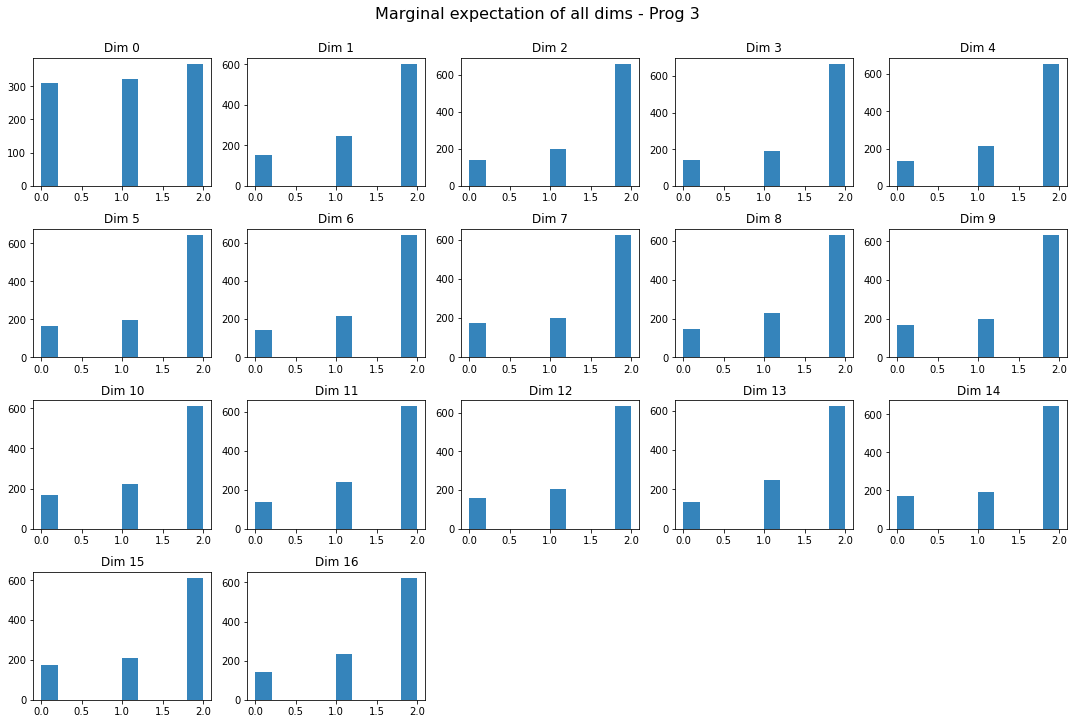

In [94]:
plot_hist(out3, 5)

In [150]:
for i in range (out3.shape[1]):
    print ('stats for dim ', i)
    print (stats.describe(out3[:,i]))

stats for dim  0
DescribeResult(nobs=1000, minmax=(0, 2), mean=1.09, variance=0.6785785785785785, skewness=-0.16798805882879608, kurtosis=-1.505613869929394)
stats for dim  1
DescribeResult(nobs=1000, minmax=(0, 2), mean=1.415, variance=0.5533283283283282, skewness=-0.8386703499555963, kurtosis=-0.7212529750249428)
stats for dim  2
DescribeResult(nobs=1000, minmax=(0, 2), mean=1.497, variance=0.5465375375375375, skewness=-1.0902161226909524, kurtosis=-0.3258102031500676)
stats for dim  3
DescribeResult(nobs=1000, minmax=(0, 2), mean=1.47, variance=0.5776776776776777, skewness=-1.0208205956538758, kurtosis=-0.5208148066499612)
stats for dim  4
DescribeResult(nobs=1000, minmax=(0, 2), mean=1.466, variance=0.5493933933933934, skewness=-0.9898500766226814, kurtosis=-0.497077147287285)
stats for dim  5
DescribeResult(nobs=1000, minmax=(0, 2), mean=1.479, variance=0.540099099099099, skewness=-1.0250224616118304, kurtosis=-0.4170886720263747)
stats for dim  6
DescribeResult(nobs=1000, minmax=

### Histogram plot for Daphne Prog 4

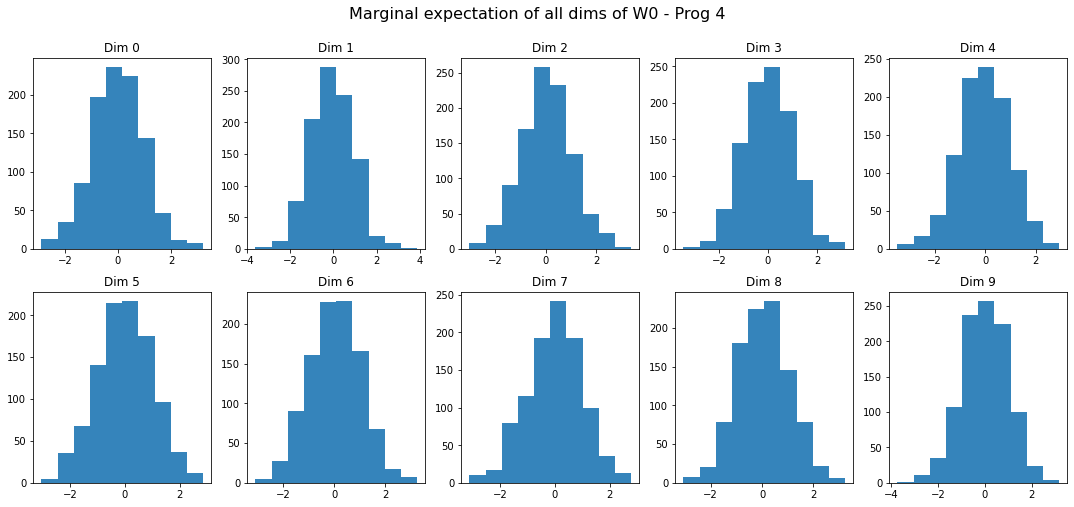

In [93]:
plot_hist(out40, 3)

In [151]:
for i in range (out40.shape[1]):
    print ('stats for dim ', i)
    print (stats.describe(out40[:,i]))

stats for dim  0
DescribeResult(nobs=1000, minmax=(-3.1750581, 2.916386), mean=0.021463921, variance=1.034464, skewness=0.09824704322326594, kurtosis=-0.09276088604337929)
stats for dim  1
DescribeResult(nobs=1000, minmax=(-2.6197374, 3.4343834), mean=0.0026179962, variance=0.978475, skewness=0.020681669906570423, kurtosis=-0.09970994904655717)
stats for dim  2
DescribeResult(nobs=1000, minmax=(-3.3121495, 3.1095645), mean=-0.02373835, variance=0.981539, skewness=0.06572760207851919, kurtosis=-0.1698519630363533)
stats for dim  3
DescribeResult(nobs=1000, minmax=(-3.098701, 3.4725409), mean=-0.0013472652, variance=1.021992, skewness=-0.04265102378964592, kurtosis=0.13992880907690086)
stats for dim  4
DescribeResult(nobs=1000, minmax=(-3.2238114, 2.7759984), mean=-0.048457008, variance=0.96383137, skewness=-0.05595322540316789, kurtosis=-0.18418209007264297)
stats for dim  5
DescribeResult(nobs=1000, minmax=(-2.8437755, 3.4318469), mean=0.07465411, variance=1.0092465, skewness=0.1103194

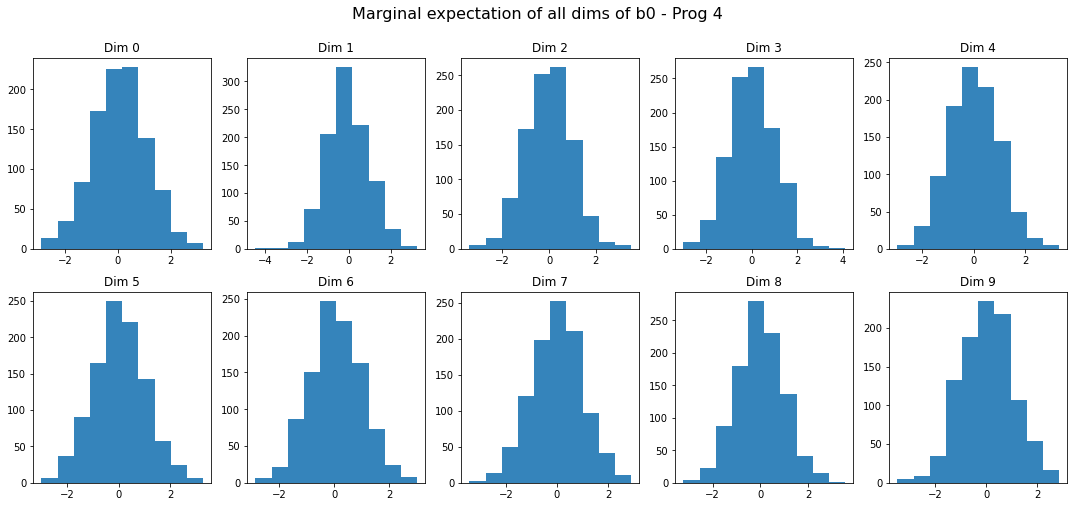

In [95]:
plot_hist(out41, 3)

In [152]:
for i in range (out41.shape[1]):
    print ('stats for dim ', i)
    print (stats.describe(out41[:,i]))

stats for dim  0
DescribeResult(nobs=1000, minmax=(-2.619289, 3.7307665), mean=-0.0023954639, variance=1.0269359, skewness=0.26065881939473934, kurtosis=0.04967998783133476)
stats for dim  1
DescribeResult(nobs=1000, minmax=(-3.5250862, 2.7712808), mean=0.009472478, variance=1.0603015, skewness=-0.06964719685737697, kurtosis=-0.055714053579723366)
stats for dim  2
DescribeResult(nobs=1000, minmax=(-3.2397115, 2.8411014), mean=0.052750915, variance=0.9490252, skewness=-0.0017551089477517384, kurtosis=-0.020613306215134575)
stats for dim  3
DescribeResult(nobs=1000, minmax=(-2.743656, 4.2475057), mean=0.040930048, variance=0.97082245, skewness=0.13227804116985045, kurtosis=0.20598812032235392)
stats for dim  4
DescribeResult(nobs=1000, minmax=(-3.5573902, 3.2778413), mean=-0.013032626, variance=1.0049828, skewness=-0.009166074906351771, kurtosis=0.007512263569264821)
stats for dim  5
DescribeResult(nobs=1000, minmax=(-2.9880688, 3.062905), mean=-0.02218321, variance=0.99036336, skewness=

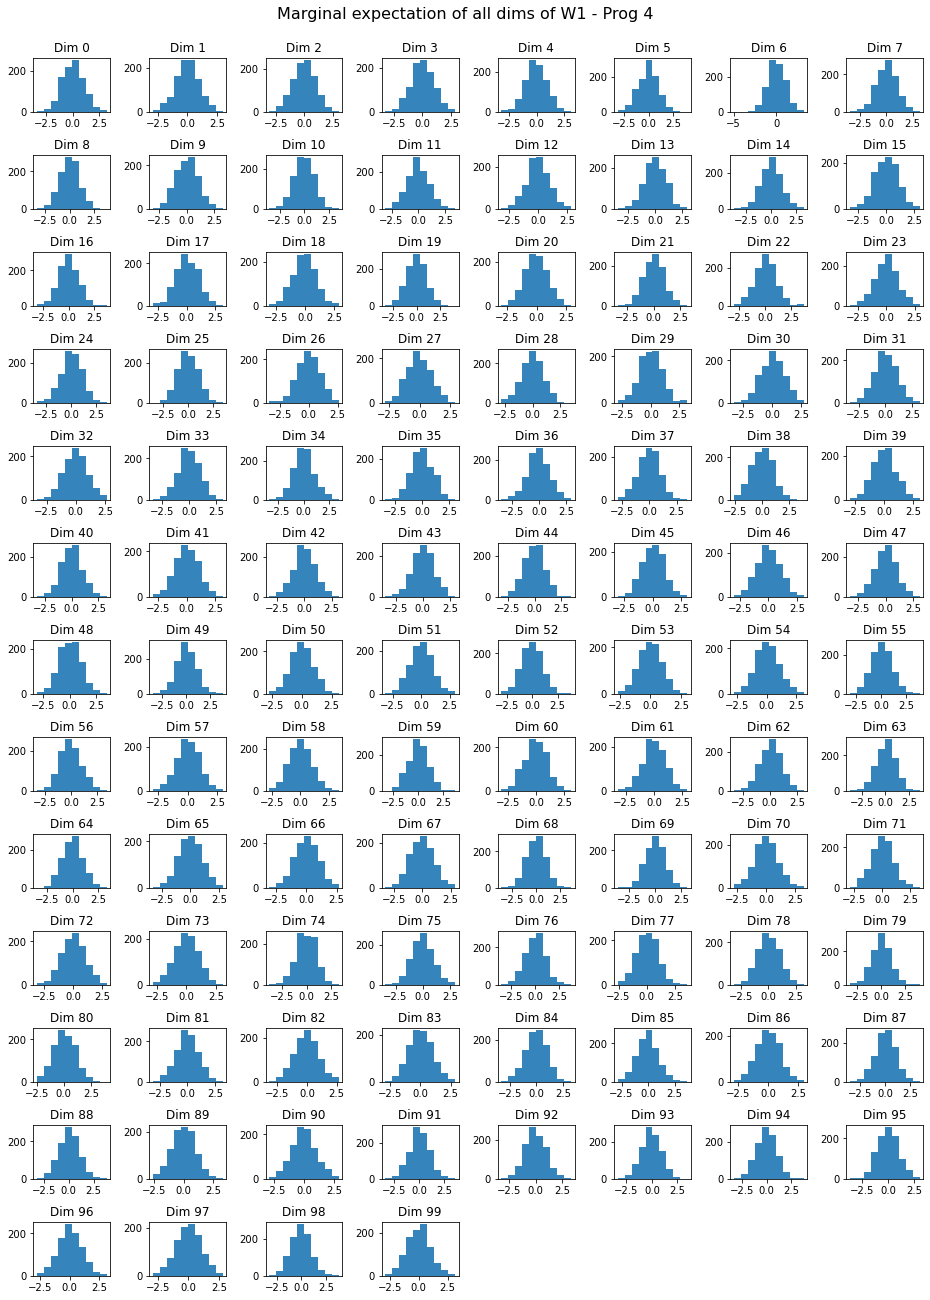

In [96]:
plot_hist(out42.view(samples, -1), 8)

In [153]:
for i in range (out42.shape[1]):
    print ('stats for dim ', i)
    print (stats.describe(out42[:,i]))

stats for dim  0
DescribeResult(nobs=1000, minmax=(array([-3.0934644, -2.8614595, -2.984888 , -3.1025746, -2.8338184,
       -3.023219 , -3.243469 , -3.2572374, -3.1936846, -2.7744994],
      dtype=float32), array([2.8461185, 4.0929017, 2.4918497, 3.012963 , 3.0100272, 3.0045087,
       3.0926945, 2.888684 , 4.175897 , 3.19128  ], dtype=float32)), mean=array([ 0.02701684, -0.05013651, -0.01080753, -0.01187216,  0.0066058 ,
        0.01000863, -0.05102206, -0.02014014, -0.02357747, -0.00193672],
      dtype=float32), variance=array([1.0882069 , 0.96647346, 0.94361657, 1.1059755 , 0.9416377 ,
       1.0048785 , 1.0040861 , 1.0439078 , 1.0151224 , 1.0057623 ],
      dtype=float32), skewness=array([ 0.00839947,  0.05368024,  0.03235938,  0.01535982,  0.06191713,
        0.00849162,  0.07921374, -0.06829583,  0.10525418,  0.06051266],
      dtype=float32), kurtosis=array([-0.16858721, -0.06231332, -0.3427248 , -0.19899607, -0.04872513,
       -0.1058476 ,  0.1583209 , -0.24079967,  0.291295

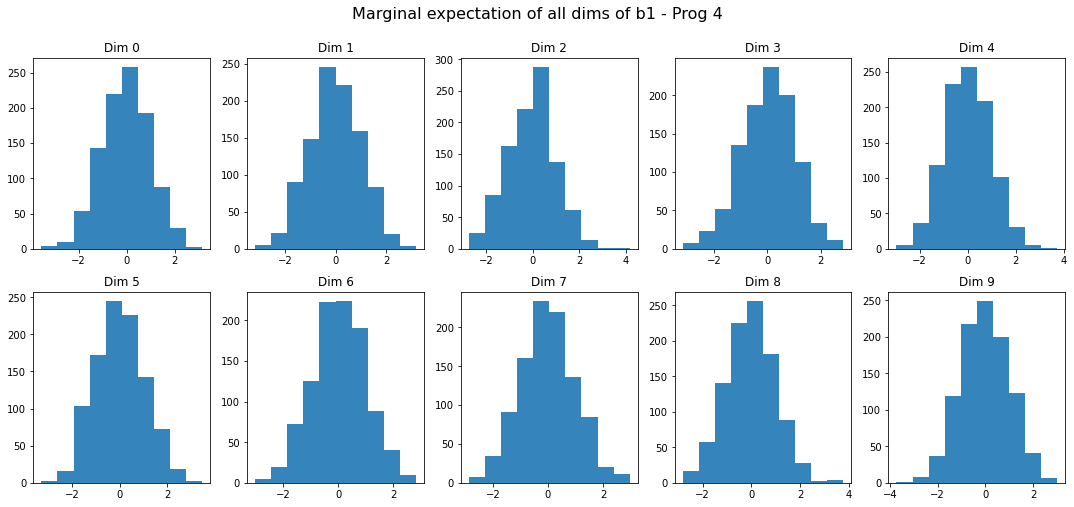

In [97]:
plot_hist(out43, 3)

In [154]:
for i in range (out43.shape[1]):
    print ('stats for dim ', i)
    print (stats.describe(out43[:,i]))

stats for dim  0
DescribeResult(nobs=1000, minmax=(-3.6111627, 3.345435), mean=0.005394638, variance=1.0707204, skewness=-0.03558036373102366, kurtosis=0.19870164476251606)
stats for dim  1
DescribeResult(nobs=1000, minmax=(-2.7795084, 3.8731618), mean=0.0033229503, variance=0.99561405, skewness=0.11961720480203612, kurtosis=0.0018896237089029988)
stats for dim  2
DescribeResult(nobs=1000, minmax=(-2.969479, 3.0555043), mean=-0.004676613, variance=0.97778714, skewness=0.003010619679789815, kurtosis=-0.04297869295368839)
stats for dim  3
DescribeResult(nobs=1000, minmax=(-3.5729055, 2.785412), mean=0.008767501, variance=0.97291493, skewness=-0.031497528195577586, kurtosis=-0.17713128946291157)
stats for dim  4
DescribeResult(nobs=1000, minmax=(-3.9801672, 3.0592375), mean=0.008519737, variance=1.0305762, skewness=-0.09506070911086441, kurtosis=0.005609277039424931)
stats for dim  5
DescribeResult(nobs=1000, minmax=(-3.8559203, 2.9608614), mean=0.052358728, variance=0.9624316, skewness=-